Final Shift Factors: [0, -2.364426666553067, -1.003666257091652, 0.775231752414701, 1.4064287777229516]
Final SSD: 3182.579383720109


/tmp/ipykernel_12244/630819719.py:119: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


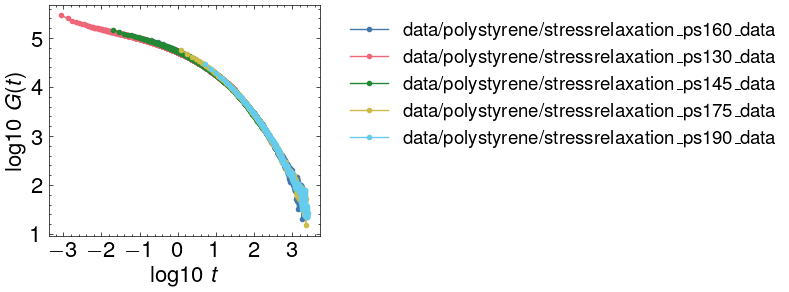

In [6]:
# Import packages
import pandas as pd
import numpy as np
import skopt
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import scienceplots # pip install scienceplots or comment out if not willing to use it

plt.style.use(['science', 'nature', 'bright']) # if not using scienceplots, remove this line

# Define column names
columns = ['Time', 'Relaxation Modulus']

# Number of iterations
num_iterations = 100

# Initialize array to store shift factor history
shift_factors_history = []

# Define a threshold for stopping (adjust this value based on your data)
ssd_threshold = 1  # Example threshold

# List of files to process
filenames = [
    'data/polystyrene/stressrelaxation_ps160_data.csv',  # Reference file with fixed shift factor 0
    'data/polystyrene/stressrelaxation_ps130_data.csv',
    'data/polystyrene/stressrelaxation_ps145_data.csv',
    'data/polystyrene/stressrelaxation_ps175_data.csv',    
    'data/polystyrene/stressrelaxation_ps190_data.csv',]

# Reference shift factor (always 0 for the reference file)
reference_shift_factor = 0

# Load the reference data (first file)
reference_data = pd.read_csv(filenames[0], decimal='.', sep='\t')
reference_data.columns = columns
reference_log_interval_time = np.log10(reference_data['Time'])
reference_log_relaxation_modulus = np.log10(reference_data['Relaxation Modulus'])

# Define the SSD calculation function
def calculate_ssd(shift_factors, filenames, reference_log_interval_time, reference_log_relaxation_modulus):
    ssd = 0.0
    for i, filename in enumerate(filenames):
        if i == 0:  # Skip reference file
            continue
        data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
        data.columns = columns
        log_interval_time = np.log10(data['Time'])
        log_relaxation_modulus = np.log10(data['Relaxation Modulus'])

        # Apply shift factor
        log_interval_time_shifted = log_interval_time + shift_factors[i]

        # Interpolate to compare with reference
        interpolated_relaxation_modulus = np.interp(reference_log_interval_time, log_interval_time_shifted, log_relaxation_modulus)
        ssd += np.sum((interpolated_relaxation_modulus - reference_log_relaxation_modulus) ** 2)
    
    return ssd

# Define the surrogate objective function for Bayesian Optimization
def surrogate_objective(shift_factors):
    return calculate_ssd([0] + list(shift_factors), filenames, reference_log_interval_time, reference_log_relaxation_modulus)

# Define the search space for Bayesian Optimization
search_space = [Real(-4, 4) for _ in range(len(filenames) - 1)]

# Perform Bayesian Optimization to find a promising region
result_bo = gp_minimize(surrogate_objective, search_space, acq_func='EI', n_calls=50, random_state=0)

# Use the result from Bayesian Optimization as the initial guess for local optimization
initial_shift_factors = result_bo.x

# Define bounds for local optimization
bounds = [(-6, 6) for _ in range(len(filenames) - 1)]

# Perform local optimization to refine the solution
def local_optimization_objective(shift_factors):
    return calculate_ssd([0] + list(shift_factors), filenames, reference_log_interval_time, reference_log_relaxation_modulus)

result_local = minimize(local_optimization_objective, initial_shift_factors, bounds=bounds, method='Powell')

# Extract the final shift factors
final_shift_factors = [0] + list(result_local.x)
print(f"Final Shift Factors: {final_shift_factors}")
print(f"Final SSD: {result_local.fun}")

time = []
G_relax = []

# Visualization
plt.figure(figsize=(3.5, 3))
for i, filename in enumerate(filenames):
    # Load the data
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns

    # Extract the relevant columns and apply log10
    log_interval_time = np.log10(data['Time'])
    log_relaxation_modulus = np.log10(data['Relaxation Modulus'])

    # Apply shift factor
    log_interval_time_shifted = log_interval_time + final_shift_factors[i]

    # Store data
    # Convert log data back to linear scale and concatenate
    time = np.concatenate([time, 10**log_interval_time_shifted])     # Merge the time arrays
    G_relax = np.concatenate([G_relax, 10**log_relaxation_modulus])  # Merge the G_relax arrays

    # Plot the data
    plt.plot(log_interval_time_shifted, log_relaxation_modulus, 'o-', label=f'{filename.split(".")[0]}')

plt.xlabel('log10 $t$', fontsize=16)
plt.ylabel('log10 $G(t)$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=13.5, bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

In [2]:
# Create a DataFrame from time and G_relax arrays
df = pd.DataFrame({'Time': time, 'G_relax': G_relax})

# Clean NaNs
df_cleaned = df.dropna()

# Reorder the DataFrame by 'Time' from minimum to maximum
df_sorted = df_cleaned.sort_values(by='Time', ascending=True).reset_index(drop=True)

# Show the DataFrame (optional)
print(df_sorted)

              Time     G_relax
0         0.000869  292000.000
1         0.001301  249000.000
2         0.001734  226000.000
3         0.002164  212000.000
4         0.002597  202000.000
...            ...         ...
11889  2503.457745      22.593
11890  2515.949540      23.796
11891  2528.696270      23.256
11892  2541.443000      26.206
11893  2554.444665      27.549

[11894 rows x 2 columns]


/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/relaxation_models.py:363: RuntimeWarning: overflow encountered in scalar power
  tau_c = (V / G)**(1 / (alpha - beta))
/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/relaxation_models.py:368: RuntimeWarning: divide by zero encountered in power
  result = G_c * np.multiply(np.power(np.divide(t, tau_c), -beta), E_function_a_b(z, a, b))
/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/relaxation_models.py:368: RuntimeWarning: invalid value encountered in multiply
  result = G_c * np.multiply(np.power(np.divide(t, tau_c), -beta), E_function_a_b(z, a, b))
/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/relaxation_models.py:364: RuntimeWarning: divide by zero encountered in scalar power
  G_c = V * (tau_c**(-alpha))
/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/relaxation_models.py:365: RuntimeWarning: divide by zero encountered in divide
  z = -np.power(np.divide(t, tau_c), alpha - beta)
/m/home/home8/81/mi

Best initial guess was: [25155180.956291392, 11789232.044630643, 0.9440499447320448, 0.1680081803099263]
G: 68418.34824115515
V: 1747729.612678094
alpha: 0.9858602290583762
beta: 0.3139823605053816
RSS: 95.64291435886422
Mean Percentage Error: 5.69%


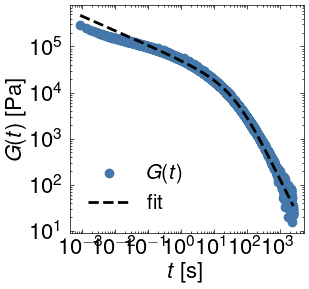

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyRheo.relaxation_model import RelaxationModel

# Load data
time_mc = df_sorted['Time'].values
G_relax_mc = df_sorted['G_relax'].values

# Downsample 'time' and 'G_relax' by selecting every 100th row
time = time_mc[::1]
G_relax = G_relax_mc[::1]

# Model fitting
model = RelaxationModel(model="FractionalMaxwell", initial_guesses="random", num_initial_guesses=10, minimization_algorithm="Powell")
model.fit(time, G_relax)
model.print_parameters()
model.print_error()
model.plot(time, G_relax, savefig=False)

In [6]:
time_predict = np.logspace(np.min(np.log10(time_mc)), np.max(np.log10(time_mc)), 100)
G_relax_predict = model.predict(time_predict)

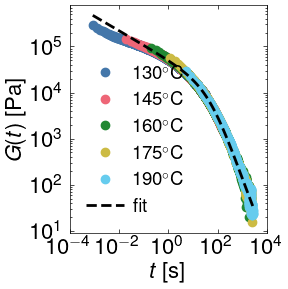

In [12]:
from matplotlib.ticker import LogLocator

# List of files to process
filenames = [
    'demos/data/stressrelaxation_ps130_data.csv',  # Reference file with fixed shift factor 0
    'demos/data/stressrelaxation_ps145_data.csv',
    'demos/data/stressrelaxation_ps160_data.csv',
    'demos/data/stressrelaxation_ps175_data.csv',    
    'demos/data/stressrelaxation_ps190_data.csv',]

s_final_shift_factors = sorted(final_shift_factors)


# Adjusted size for better visibility of multiple plots
plt.figure(figsize=(3, 3))

# Reordered labels based on temperatures (minimum temperature first)
labels = ["$130^{\circ}$C", "$145^{\circ}$C", "$160^{\circ}$C", "$175^{\circ}$C", "$190^{\circ}$C"]


# Visualization
for i, filename in enumerate(filenames):
    # Load the data
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns

    # Extract the relevant columns and apply log10
    log_interval_time = np.log10(data['Time'])
    log_relaxation_modulus = np.log10(data['Relaxation Modulus'])

    # Apply shift factor
    log_interval_time_shifted = log_interval_time + s_final_shift_factors[i]

    # Store data
    # Convert log data back to linear scale and concatenate
    time = np.concatenate([time, 10**log_interval_time_shifted])            # Merge the time arrays
    G_relax = np.concatenate([G_relax, 10**log_relaxation_modulus])  # Merge the G_relax arrays
    
    # Assign label from reordered list based on the current index i
    label = labels[i]
    
    # Plot the data
    plt.plot(10**log_interval_time_shifted, 10**log_relaxation_modulus, 'o', markersize=6, label=label)


# Plot the results
#plt.plot(time_mc, G_relax_mc, 'o', markersize=6, label='master curve')
plt.plot(time_predict, G_relax_predict, '--', color="k", lw=2, label='fit')

# Customize the plot
plt.xscale("log")
plt.yscale("log")

# Adjust the tick locations on both axes to avoid crowding
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))  # X-axis log ticks
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))  # Y-axis log ticks

# Font sizes for the ticks, labels, and legend
plt.xlim(1e-4, 8e4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$t$ [s]', fontsize=16)
plt.ylabel(r'$G(t)$ [Pa]', fontsize=16)
plt.legend(fontsize=13.5, loc='lower left', ncol=1, handletextpad=0.5)

# Add final touches to the plot
plt.grid(False)
plt.tight_layout()

# Save and display the plot
plt.savefig("ps_relaxation_mc.pdf", format="pdf", bbox_inches='tight')
plt.show()